In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
from lib.DrugUtil import flatten, DrugUtil
import matplotlib.pyplot as plt

import plotly.express as px

from lib.FhirDataUtil import FhirDataUtil
from lib.CCSDataUtil import CCSDataUtil
from IPython.display import display, HTML


def printmd(string):
    display(string)

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

_output_dir = 'output/'

_rxnorm_file = "input_static/RxTerms202203/RxTerms202203.txt"
_rxnorm_ingredients_file = "input_static/RxTerms202203/RxTermsIngredients202203.txt"
_rxclass_file = "input_static/_rxclass_2022-04-10.csv"

_pc_demographics_file = "input/pcornet/demographic_fhir.csv"
_pc_medications_file = "input/pcornet/med_pres_fhir_v2.csv"
_pc_medications_query_file = "input/pcornet/pc_medications_query.xlsx"
_pc_conditions_file = "input/pcornet/diagnosis_fhir.csv"


_cache_dir = 'cache/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
fhirUtil = FhirDataUtil()
drugUtil = DrugUtil()
drugUtil.load(rxnorm_file=_rxnorm_file,
                        rxnorm_ingredients_file=_rxnorm_ingredients_file, 
                        rxclass_file=_rxclass_file)



Reading rxclass file...
Reading rxnorm file...


In [13]:
# Load PC demo

pc_meds_raw = pd.read_csv(_pc_medications_file)
pc_demo = pd.read_csv(_pc_demographics_file)

def generate_ingredients_column(row, colName='rx'):
#     print('--------', row['raw_rx_med_name'])
    s = drugUtil.findIngredientsByRxcui(row[colName], verbose=False)
    if s is not None:
        return s['ING_RXCUI'].array
    else:
        return np.nan
pc_meds = pc_meds_raw.copy()
pc_meds['rx_order_date_d'] = pd.to_datetime(pc_meds['rx_order_date'])

# pc_meds['rxcui_ing'] = pc_meds.apply(generate_ingredients_column, axis=1)
# pc_meds = pc_meds.explode('rxcui_ing')

pc_meds_query = pd.read_excel(_pc_medications_query_file)
pc_meds_query = pc_meds_query[pc_meds_query['CODETYPE'] == 'RXCUI']
print('Total Entries (includes multiple for ingredients) ', len(pc_meds))

Total Entries (includes multiple for ingredients)  7789


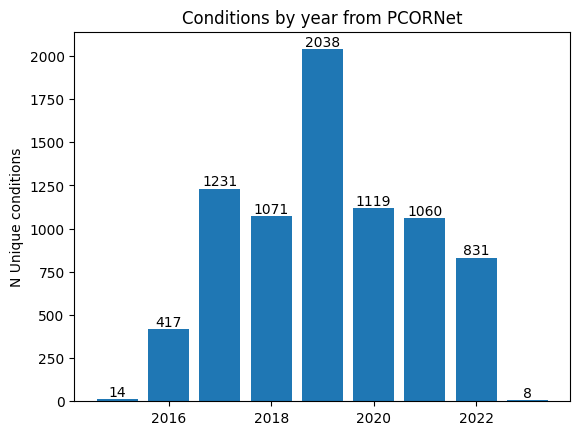

6924   2015-12-01
6964   2015-12-02
7036   2015-12-03
651    2015-12-05
548    2015-12-05
          ...    
4245   2023-02-11
4159   2023-03-11
4246   2023-03-11
4409   2023-04-21
4360   2023-04-21
Name: rx_order_date_d, Length: 7789, dtype: datetime64[ns]

In [14]:
import matplotlib.pyplot as plt
years = pc_meds['rx_order_date_d'].dt.year.value_counts().reset_index(name="Medications")
bar = plt.bar(years['index'], years['Medications'])
plt.bar_label(bar)
plt.title('Conditions by year from PCORNet')
plt.ylabel('N Unique conditions')
plt.show()
pc_meds['rx_order_date_d'].dropna().sort_values()

In [29]:
pc_demo.groupby('user_id')['provider'].count().sort_values()

user_id
20        1
514221    1
514533    1
514559    1
514661    1
         ..
494227    1
494281    1
494308    1
493739    1
558116    1
Name: provider, Length: 629, dtype: int64

In [16]:
# Limit FHIR to PC provider

site_config = {
    'UCSFHEALTHPARTN': 'openepic_shared_ucsf_health',
    'UT1PARTNER': 'openepic_shared_university_of_utah_healthcare',
    'NY1PARTNER': 'openepic_shared_nyu_langone_medical_center',
    'SH2PARTNER': 'openepic_shared_sutter_health',
    'OS2PARTNER': 'openepic_shared_ochsner_health_system',
    'MF1PARTNER': 'openepic_shared_montefiore_medical_center',
    'BA1PARTNER': 'openepic_shared_baylor_scott_white'
}
pc_demo['provider'] = pc_demo['siteid'].replace(site_config)
pc_demo_m = pc_demo.drop_duplicates(['user_id', 'provider'])

# fhir_meds_pc = fhir_meds.merge(pc_demo_m, left_on=['user_id', 'provider'], right_on=['user_id', 'pc_site'], how='inner')
# print('FHIR length after only keeping PC sites:', len(fhir_meds_pc))

# Add provider information to pc_meds
pc_meds_s = pc_meds.merge(pc_demo_m, on='user_id', how='left')

print('After subgroup selection','PC', len(pc_meds_s))

After subgroup selection PC 7789


In [17]:
pc_demo_m['provider'].value_counts()

openepic_shared_ucsf_health                      156
openepic_shared_university_of_utah_healthcare    136
openepic_shared_nyu_langone_medical_center       112
openepic_shared_sutter_health                    111
openepic_shared_ochsner_health_system             56
openepic_shared_montefiore_medical_center         31
openepic_shared_baylor_scott_white                27
Name: provider, dtype: int64

In [7]:
print('PC meds', len(pc_meds_s))
pc_meds_s = pc_meds_s.drop_duplicates(['user_id', 'rx'])
print('PC meds after dropping duplicates', len(pc_meds_s))

pc_meds_s = pc_meds_s.merge(drugUtil.rxnormIngr, right_on='RXCUI', left_on='rx', how='left', indicator='pc_ingr_merge')
pc_meds_s = pc_meds_s.rename(columns={'ING_RXCUI': 'pc_ing_code', 'INGREDIENT': 'pc_ing_name'})
# pc_meds_s = pc_meds_s.drop('match', axis=1)
print('PC meds', len(pc_meds_s))
pc_meds = pc_meds_s
pc_meds['pc_ing_code'] = pc_meds['pc_ing_code'].astype('Int64')
pc_meds['pc_ingr_merge'].value_counts()



PC meds 7789
PC meds after dropping duplicates 1596
PC meds 1679


both          1540
left_only      139
right_only       0
Name: pc_ingr_merge, dtype: int64

In [10]:
pc_meds.to_csv(_cache_dir+'pc_meds_mapped.csv')

In [24]:
pc_meds['concept_lbl']

,v1,user_id,prescribingid,concept_id,concept_lbl,rx,rx_type,rx_order_date,rx_start_date,rx_end_date,rx_days_supply,rx_refills,raw_rx_med_name,encounterid,query_date,datamartid,rx_order_date_d
0,26,502639,{CCB4BB82-4C07-4981-BAB9-8A7E43BF96D1},MD_CORTICSTD,CORTICOSTEROID,966522,RXCUI,23oct2017,23oct2017,19jan2018,1.0,3.0,BUDESONIDE 180 MCG/ACT IN AEPB,886152381,23jan2023,SUTTER,2017-10-23
1,26,502639,{B9E5AF5B-7450-4892-A82D-626AAD013DA8},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,28dec2018,28dec2018,NaN,1.0,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,952334898,23jan2023,SUTTER,2018-12-28
2,26,502639,{C3AF0BC2-0F3F-4B7C-AA4C-9BD6FD87F644},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,20dec2018,20dec2018,28dec2018,NaN,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,947684175,23jan2023,SUTTER,2018-12-20
3,26,502639,{2CC6A9B0-E44C-49BC-B4C6-0EDEE64D37D4},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,17oct2017,17oct2017,19jan2018,NaN,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,885230200,23jan2023,SUTTER,2017-10-17
4,117,545573,76186567-1,MD_LMW_HEPARIN,LMW_HEPARIN,854235,RXCUI,25nov2020,25nov2020,25nov2020,NaN,NaN,Enoxaparin Sodium Inj 40 MG/0.4M,UTAH20074378,12jan2023,C4UU,2020-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,43448,520958,10325248-1,MD_CORTICSTD,CORTICOSTEROID,1085754,RXCUI,19dec2018,19dec2018,19dec2018,NaN,NaN,Triamcinolone Acetonide Inj Susp 40 MG/M,UTAH14344938,12jan2023,C4UU,2018-12-19
7785,46703,542317,62065465,MD_DEXAMETH,DEXAMETHASONE,1116927,RXCUI,20aug2018,20aug2018,NaN,NaN,NaN,NaN,43663484,03feb2023,C8NYU,2018-08-20
7786,46703,542317,60377948,MD_CORTICSTD,CORTICOSTEROID,1359779,RXCUI,07feb2020,07feb2020,11jul2022,NaN,0.0,NaN,43449328,03feb2023,C8NYU,2020-02-07
7787,46703,542317,59574810,MD_DEXAMETH,DEXAMETHASONE,1116927,RXCUI,20aug2018,20aug2018,20aug2018,NaN,NaN,NaN,43663484,03feb2023,C8NYU,2018-08-20


In [15]:
pc_meds['concept_lbl'].value_counts()

CORTICOSTEROID          722
DEXAMETHASONE           238
HEPARIN                 153
ASPIRIN                 136
IMMUNOSUPPRESSANT       125
AZITHROMYCIN             78
LMW_HEPARIN              73
FACTORXA_INHIBITOR       58
VITAMINK_ANTAGONIST      32
ANTIPLATELET THERAPY     21
COLCHICINE               14
HYDROXYCHLOROQUINE        8
THROMBIN_INHIBITOR        6
THROMBOLYTIC_MED          6
REMDESIVIR                2
CASIRIVIMAB               2
IVERMECTIN                2
TOCILIZUMAB               1
BAMLANIVIMAB              1
ETESEVIMAB                1
Name: concept_lbl, dtype: int64

In [14]:
pc_demo['user_id'].nunique()

629

In [30]:
pc_meds_raw[pc_meds_raw['user_id'] == 533877]

,v1,user_id,prescribingid,concept_id,concept_lbl,rx,rx_type,rx_order_date,rx_start_date,rx_end_date,rx_days_supply,rx_refills,raw_rx_med_name,encounterid,query_date,datamartid
147,585,533877,50573795,MD_CORTICSTD,CORTICOSTEROID,1797935,RXCUI,06sep2019,06sep2019,NaN,NaN,NaN,NaN,6645748,03feb2023,C8NYU
148,585,533877,50427078,MD_ANTIPLT,ANTIPLATELET THERAPY,309362,RXCUI,02jun2022,02jun2022,NaN,NaN,3.0,NaN,6882780,03feb2023,C8NYU


In [34]:
cr_users = [35829,
 477473,
 462377,
 454596,
 378622,
 457587,
 465182,
 458578,
 481303,
 433846,
 480918,
 459181,
 457363]
pc_demo[pc_demo['user_id'].isin(cr_users)][['user_id','provider']]

,user_id,provider
16,35829,openepic_shared_ucsf_health
66,458578,openepic_shared_ucsf_health
71,477473,openepic_shared_ucsf_health
157,457587,openepic_shared_ucsf_health
193,454596,openepic_shared_ucsf_health
215,433846,openepic_shared_ucsf_health
270,480918,openepic_shared_ucsf_health
286,459181,openepic_shared_ucsf_health
390,465182,openepic_shared_ucsf_health
410,457363,openepic_shared_ucsf_health


# PC Query Meds

In [20]:
pc_meds_query_s = pc_meds_query.merge(drugUtil.rxnormIngr, right_on='RXCUI', left_on='CODE', how='left', indicator='ingr_merge')
pc_meds_query_s = pc_meds_query_s.rename(columns={'ING_RXCUI': 'ing_code', 'INGREDIENT': 'ing_name'})
print('query meds', len(pc_meds_query_s))
pc_meds_query_s['ingr_merge'].value_counts()

query meds 4879


left_only     4218
both           661
right_only       0
Name: ingr_merge, dtype: int64

In [22]:
pc_meds_query_s.to_csv(_cache_dir+'/pc_meds_query.csv')

In [26]:
pc_meds_query_s['CONCEPT_LBL'].value_counts()

CORTICOSTEROID          2076
ASPIRIN                  836
IMMUNOSUPPRESSANT        668
HEPARIN                  358
DEXAMETHASONE            297
LMW_HEPARIN              150
IVERMECTIN               113
THROMBOLYTIC_MED         109
FACTORXA_INHIBITOR        37
THROMBIN_INHIBITOR        36
ANTIPLATELET THERAPY      36
TOCILIZUMAB               29
SARILUMAB                 23
AZITHROMYCIN              19
IMDEVIMAB                 17
CASIRIVIMAB               17
SILTUXIMAB                13
VITAMINK_ANTAGONIST       13
REMDESIVIR                11
COLCHICINE                 9
ETESEVIMAB                 4
BAMLANIVIMAB               4
HYDROXYCHLOROQUINE         2
FLUVOXAMINE                1
BARICITINIB                1
Name: CONCEPT_LBL, dtype: int64